In [48]:
# !pip install yahoofinancials
# !pip install yfinance
# !pip install --upgrade tensorflow

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import os

# Get Data
amd_stock = yf.Ticker('GOOG')
amd_historyAll = amd_stock.history(period="5y").reset_index()

# Delete date since numbers are just fine
amd_historyAll.pop('Date')

# Round Data to be divisible by 50
rounded = 50 * round(len(amd_historyAll)/50)
limitOfDelete = len(amd_historyAll) - rounded
tempList = list(range(0,limitOfDelete))

# Drop Date (useless information that the model doesn't need to know)
amd_historyAll = amd_historyAll.drop(amd_historyAll.index[tempList])
amd_historyAll = amd_historyAll.reset_index()
amd_historyAll.pop('index')
amd_historyAll.pop('Dividends')
amd_historyAll.pop('Stock Splits')
amd_historyAll.to_csv()

# Creating blank variables
xtrainingAll = amd_historyAll[0:1000]
xtestingAll = amd_historyAll[950:1250]

# Normalize, but wont change distribution and weights
scaler = MinMaxScaler(feature_range=(-1,1))
xtrainingAll1 = scaler.fit_transform(xtrainingAll)
xtestingAll1 = scaler.transform(xtestingAll)

xtestingAllFinal = []
ytestingAllFinal = []
xtrainingAllFinal = []
ytrainingAllFinal = []

for x in range(50, xtrainingAll1.shape[0]):
    xtrainingAllFinal.append(xtrainingAll1[x-50:x])
    ytrainingAllFinal.append(xtrainingAll1[x,0])

for x in range(50, xtestingAll5.shape[0]):
    xtestingAllFinal.append(xtestingAll1[x-50:x])
    ytestingAllFinal.append(xtestingAll1[x,0])

xtrainingAllFinal,xtestingAllFinal = np.array(xtrainingAllFinal),np.array(xtestingAllFinal)
ytrainingAllFinal,ytestingAllFinal = np.array(ytrainingAllFinal),np.array(ytestingAllFinal)
print(xtrainingAllFinal.shape)
print(ytrainingAllFinal.shape)
print(xtestingAllFinal.shape)
print(ytestingAllFinal.shape)


(950, 50, 5)
(950,)
(200, 50, 5)
(200,)


In [58]:
if os.path.exists("model1"):
  model = tf.keras.models.load_model('model1')
else:
  # Creating Model 1
  # ? So I want to try starting the first layer with double the amount of neurons as the input size however have 50% dropout
  model = Sequential()
  # Input Layer
  model.add(LSTM(units = 120, input_shape=(xtrainingAllFinal.shape[1],5), return_sequences = True))
  # Hidden Layers
  model.add(Dropout(0.3))
  model.add(LSTM(units = 150, return_sequences = True))
  model.add(Dropout(0.4))
  model.add(LSTM(units = 180, return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(units = 200))
  model.add(Dropout(0.6))
  # Output Layer
  model.add(Dense(units = 1))

  model.summary()
  model.compile(optimizer = 'adam', loss = "mean_squared_error",metrics=["mean_squared_error"])
  history = model.fit(xtrainingAllFinal,ytrainingAllFinal,epochs=100,batch_size = 32,validation_data=(xtestingAllFinal,ytestingAllFinal),verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 50, 120)           60480     
_________________________________________________________________
dropout_40 (Dropout)         (None, 50, 120)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 50, 150)           162600    
_________________________________________________________________
dropout_41 (Dropout)         (None, 50, 150)           0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 50, 180)           238320    
_________________________________________________________________
dropout_42 (Dropout)         (None, 50, 180)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 200)             

MinMax:  MinMaxScaler(feature_range=(-1, 1))
[2.34172858e-03 2.32610620e-03 2.33068715e-03 2.32983488e-03
 3.41326052e-07]


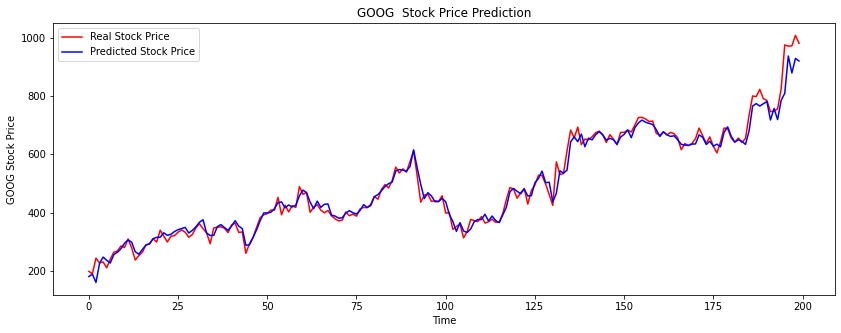

In [59]:
# Test Model
yPred = model.predict(xtestingAllFinal)
# print('Scaler: ',scaler.scale_)
print('MinMax: ',scaler)
print(scaler.scale_)

scl = 1/scaler.scale_[0]  

yPred1 = scl * yPred
ytestingAllFinal1 = scl * ytestingAllFinal
plt.figure(figsize=(14,5))
plt.plot(ytestingAllFinal1, color = 'red', label = "Real Stock Price")
plt.plot(yPred1, color = 'blue', label = "Predicted Stock Price")
plt.title('GOOG  Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show()


In [ ]:
print(yPred1)
print(ytestingAllFinal)

In [64]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytestingAllFinal1.tolist(),yPred1.tolist(), squared=False)

25.422281397056242

In [61]:
type(ytestingAllFinal1)

numpy.ndarray